In [43]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points, transform
import matplotlib.pyplot as plt
import seaborn as sns
import pyproj

# === Setup ===
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None

# Load and prepare data
matched_flowlines_gdf = gpd.read_file('interpolated_clean_flowlines.geojson')
matched_flowlines_gdf = matched_flowlines_gdf.to_crs(epsg=4326)
og_length = len(matched_flowlines_gdf)
print(f"Original number of flowlines: {og_length}")

colnames = matched_flowlines_gdf.columns.tolist()
colnames

Original number of flowlines: 112138


['unique_id',
 'operator_name',
 'operator_number',
 'flowline_id',
 'location_id',
 'status',
 'flowline_action',
 'location_type',
 'fluid',
 'material',
 'diameter_in',
 'length_ft',
 'max_operating_pressure',
 'line_age_yr',
 'construct_date',
 'risk',
 'geometry']

In [44]:
# === Step 1: Compute global min/max BEFORE filtering ===
geod = pyproj.Geod(ellps="WGS84")

def compute_geod_length(geom):
    if isinstance(geom, MultiLineString):
        return sum(geod.geometry_length(line) for line in geom.geoms)
    elif isinstance(geom, LineString):
        return geod.geometry_length(geom)
    else:
        return 0.0

matched_flowlines_gdf['geod_length_m'] = matched_flowlines_gdf['geometry'].apply(compute_geod_length)

original_min = matched_flowlines_gdf['geod_length_m'].min()
original_max = matched_flowlines_gdf['geod_length_m'].max()
print(f"Original global min length (m): {original_min:.4f}")
print(f"Original global max length (m): {original_max:.2f}")

Original global min length (m): 0.0000
Original global max length (m): 46336.88


In [45]:
# === Step 2: Filter for flowlines >= 1 meter ===
min_valid_length = 1.0
filtered_flowlines_gdf = matched_flowlines_gdf[matched_flowlines_gdf['geod_length_m'] >= min_valid_length].copy()

n_original = len(matched_flowlines_gdf)
n_filtered = len(filtered_flowlines_gdf)
print(f"Remaining flowlines ≥ {min_valid_length} m: {n_filtered}")
print(f"Filtered out: {n_original - n_filtered}")

# Recalculate global min/max
filtered_min = filtered_flowlines_gdf['geod_length_m'].min()
filtered_max = filtered_flowlines_gdf['geod_length_m'].max()
print(f"Filtered global min length (m): {filtered_min:.4f}")
print(f"Filtered global max length (m): {filtered_max:.2f}")

Remaining flowlines ≥ 1.0 m: 108065
Filtered out: 4073
Filtered global min length (m): 1.0003
Filtered global max length (m): 46336.88


In [46]:
# === Step 3: Build length array for plotting ===
line_lengths = []
for geom in filtered_flowlines_gdf['geometry']:
    if isinstance(geom, MultiLineString):
        for line in geom.geoms:
            line_lengths.append(geod.geometry_length(line))
    elif isinstance(geom, LineString):
        line_lengths.append(geod.geometry_length(geom))

line_lengths = np.array(line_lengths)
line_lengths = line_lengths[line_lengths >= 1.0]

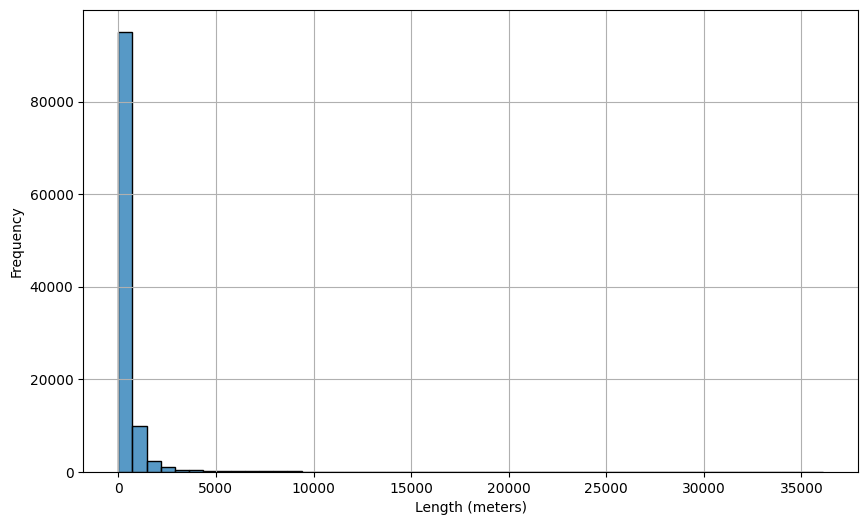

In [47]:
# === Histogram 1: Full distribution ===
plt.figure(figsize=(10, 6))
sns.histplot(line_lengths, bins=50) #kde=True
# plt.title('Distribution of Geodesic LineString Lengths (All ≥ 1 m)')
plt.xlabel('Length (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

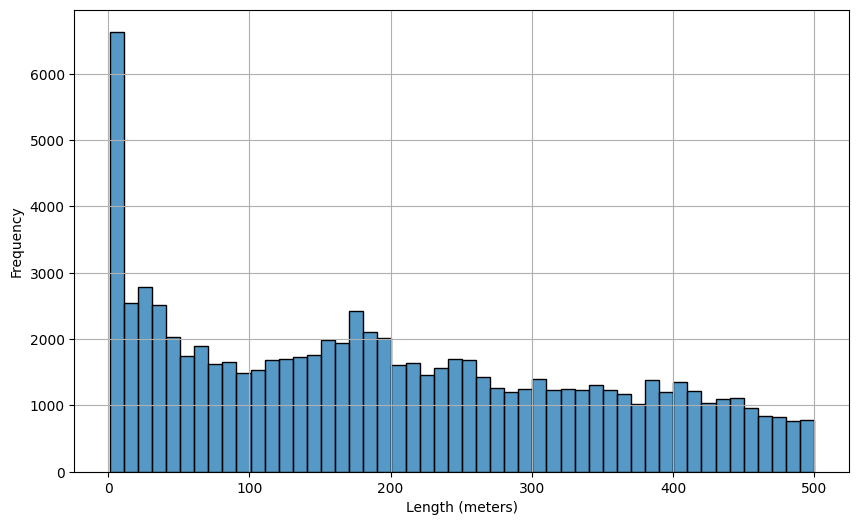

In [48]:
# === Histogram 2: Truncated at 500 m ===
max_length_to_plot = 500
truncated_lengths = line_lengths[line_lengths <= max_length_to_plot]

plt.figure(figsize=(10, 6))
sns.histplot(truncated_lengths, bins=50) #kde=True
# plt.title(f'Distribution of Geodesic Lengths (1–{max_length_to_plot} m)')
plt.xlabel('Length (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


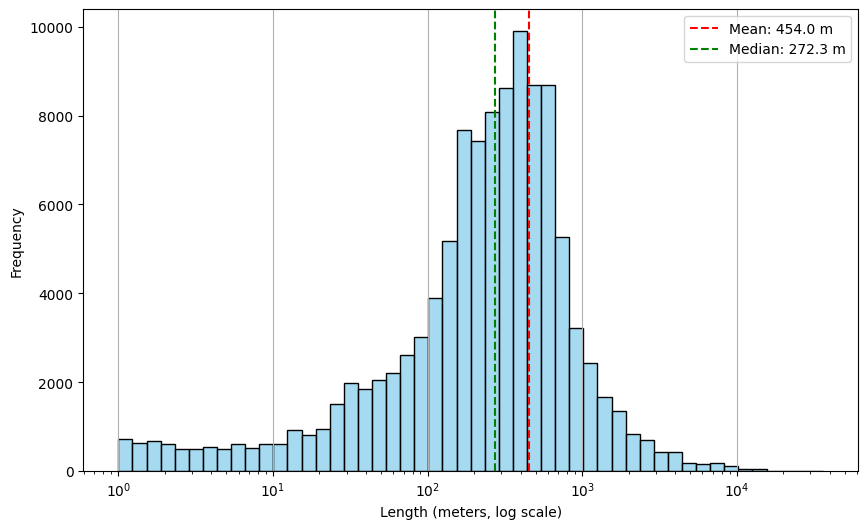

In [49]:
# === Histogram 3: Log-scaled X-axis ===
mean_len = np.mean(line_lengths)
median_len = np.median(line_lengths)
# min_len = np.min(line_lengths)
# max_len = np.max(line_lengths)

plt.figure(figsize=(10, 6))
sns.histplot(line_lengths, bins=50, kde=False, log_scale=(True, False), color='skyblue')

plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f} m')
plt.axvline(median_len, color='green', linestyle='--', label=f'Median: {median_len:.1f} m')
# plt.axvline(min_len, color='purple', linestyle='--', label=f'Min: {min_len:.1f} m')
# plt.axvline(max_len, color='orange', linestyle='--', label=f'Max: {max_len:.1f} m')

# plt.title('Distribution of Geodesic Lengths (Log X-axis, All ≥ 1 m)')
plt.xlabel('Length (meters, log scale)')
plt.ylabel('Frequency')
plt.grid(True, which='major', axis='x')  # ✅ Fix: only major gridlines
plt.legend()
plt.show()

In [50]:
import geopandas as gpd
import numpy as np
from shapely.ops import linemerge

# --- Load data ---
gdf = gpd.read_file("interpolated_clean_flowlines.geojson")
print(f"Original number of flowlines: {len(gdf)}")

# Project to meters so spacing = meters
gdf_m = gdf.to_crs(gdf.estimate_utm_crs())

points_list = []
for idx, row in gdf_m.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    
    # Merge MultiLineString parts into one continuous line if needed
    if geom.geom_type == "MultiLineString":
        geom = linemerge(geom)
    
    length = geom.length
    distances = np.arange(0, length + 1e-9, 50)  # every 50 m
    
    for d in distances:
        pt = geom.interpolate(d)
        new_row = row.drop(labels="geometry")
        new_row["geometry"] = pt
        points_list.append(new_row)

# Create points GeoDataFrame
points_gdf = gpd.GeoDataFrame(points_list, geometry="geometry", crs=gdf_m.crs)

# Back to original CRS if needed
points_gdf = points_gdf.to_crs(gdf.crs)

# Save to file#
points_gdf.to_file("flowline_points_50m.geojson", driver="GeoJSON")

# --- Summary ---
print(f"Segmented into {len(points_gdf)} point features.")

Original number of flowlines: 112138
Segmented into 1060591 point features.


In [51]:
# 0) Prep: load points, build a coordinate key, and sanity stats

points_gdf = gpd.read_file("flowline_points_50m.geojson")   

# Keep only valid Points
valid = (
    points_gdf.geometry.notna()
    & (~points_gdf.geometry.is_empty)
    & (points_gdf.geometry.type == "Point")
)
points_gdf = points_gdf.loc[valid].copy()

# Coordinate key (rounded to curb float noise)
points_gdf["coord_key"] = points_gdf.geometry.apply(lambda p: (round(p.x, 6), round(p.y, 6)))

print(f"Total valid points: {len(points_gdf)}")
print(f"Unique coordinate locations in points: {points_gdf['coord_key'].nunique()}")

Total valid points: 1060588
Unique coordinate locations in points: 413943


In [52]:
#1) Split into unique and duplicate (including first) point rows
# value_counts on coord_key
vc = points_gdf["coord_key"].value_counts()

# Unique rows: coord_key occurs exactly once
unique_mask = points_gdf["coord_key"].map(vc).eq(1)
unique_50_points = points_gdf.loc[unique_mask].copy()

# Duplicate rows (include the first instance): coord_key occurs >= 2
dup_mask_all = points_gdf["coord_key"].map(vc).ge(2)
dup_50_points = points_gdf.loc[dup_mask_all].copy()

print(f"Unique (non-dup) rows: {len(unique_50_points)}")
print(f"Duplicate rows (incl. first): {len(dup_50_points)}")

Unique (non-dup) rows: 234270
Duplicate rows (incl. first): 826318


In [53]:
#2) From duplicates, keep those whose unique_id appears in spills; if multiple per coord, keep first
spills_gdf = gpd.read_file("spills_w_flowline_attributes.geojson")  # has 'unique_id'
spills_ids = set(spills_gdf["unique_id"].dropna())

# Subset of duplicates where unique_id is in spills
dup_in_spills = dup_50_points[dup_50_points["unique_id"].isin(spills_ids)].copy()

# Per coord_key in this subset, keep first occurrence (deterministic)
dup_in_spills_kept = dup_in_spills.sort_index().drop_duplicates(subset=["coord_key"], keep="first")

print(f"Duplicate rows with unique_id in spills (rows): {len(dup_in_spills)}")
print(f"Kept (one per coord_key) from that subset:       {len(dup_in_spills_kept)}")

Duplicate rows with unique_id in spills (rows): 4685
Kept (one per coord_key) from that subset:       4684


In [54]:
# 3) Remove those kept coord_keys from the remaining duplicate pool
kept_keys = set(dup_in_spills_kept["coord_key"])

# Remaining duplicates = all dup rows EXCEPT the coord_keys we already satisfied via spills
dup_remaining = dup_50_points[~dup_50_points["coord_key"].isin(kept_keys)].copy()

print(f"Remaining duplicate rows after spills-keep: {len(dup_remaining)}")

Remaining duplicate rows after spills-keep: 802396


In [55]:
#4) For the remaining duplicate coord_keys, pick one random row per coord_key
# One random representative per remaining coord_key (reproducible)
dup_remaining_keep = (
    dup_remaining.groupby("coord_key", group_keys=False)
                 .apply(lambda df: df.sample(n=1, random_state=42))
)

print(f"Random-kept from remaining duplicate groups: {len(dup_remaining_keep)}")

Random-kept from remaining duplicate groups: 174989


/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_12075/1592186823.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(n=1, random_state=42))


In [56]:
#5) Combine: unique (non-dup) + kept-from-spills + random-kept-from-remaining
final_points = gpd.GeoDataFrame(
    pd.concat([unique_50_points, dup_in_spills_kept, dup_remaining_keep], ignore_index=True),
    geometry="geometry",
    crs=points_gdf.crs
)

# Optional: drop helper column before saving
final_points = final_points.drop(columns=["coord_key"])

print(f"Final points after de-dup pipeline: {len(final_points)}")

Final points after de-dup pipeline: 413943


In [ ]:
#6) Count check: final count should equal number of unique coordinate locations in the original points
expected_unique_coords = points_gdf["coord_key"].nunique()
got = len(final_points)

print(f"Expected unique coords: {expected_unique_coords}")
print(f"Got final rows:         {got}")
print("PASS ✅" if got == expected_unique_coords else "MISMATCH ❌")

Expected (unique coord locations): 413943
Got (final rows):                  413943
PASS ✅


In [58]:
final_points.to_file("flowline_points_50m_dedup.geojson", driver="GeoJSON")

In [26]:
import geopandas as gpd

# points_gdf = gpd.read_file("flowline_points_50m.geojson")

# Keep only valid, non-empty Points
mask_valid = (
    points_gdf.geometry.notna()
    & (~points_gdf.geometry.is_empty)
    & (points_gdf.geometry.type == "Point")
)
skipped = len(points_gdf) - mask_valid.sum()
if skipped:
    print(f"Skipping {skipped} empty/non-Point geometries.")

pts = points_gdf.loc[mask_valid].copy()

# Round coords to tame float noise, then count duplicates
coords_rounded = pts.geometry.apply(lambda p: (round(p.x, 6), round(p.y, 6)))
dup_count = coords_rounded.duplicated().sum()

print(f"Number of duplicate points: {dup_count}")


Number of duplicate points: 646645


In [27]:
import geopandas as gpd

# --- Load files ---
# points_gdf = gpd.read_file("flowline_points_50m.geojson")
spills_gdf = gpd.read_file("spills_w_flowline_attributes.geojson")

# Keep only valid Points
mask_valid = (
    points_gdf.geometry.notna()
    & (~points_gdf.geometry.is_empty)
    & (points_gdf.geometry.type == "Point")
)
points_gdf = points_gdf.loc[mask_valid].copy()

# --- Identify duplicates by rounded coordinates ---
coords_rounded = points_gdf.geometry.apply(lambda p: (round(p.x, 6), round(p.y, 6)))
points_gdf["coord_key"] = coords_rounded
dup_mask = coords_rounded.duplicated(keep=False)  # mark all members of a duplicate group
dups = points_gdf.loc[dup_mask].copy()

# --- Count duplicates whose unique_id is also in spills ---
spills_ids = set(spills_gdf["unique_id"].dropna())
dups_with_spills_id = dups[dups["unique_id"].isin(spills_ids)]

print(f"Total duplicate points: {dup_mask.sum()}")
print(f"Duplicate points with unique_id in spills dataset: {len(dups_with_spills_id)}")

Total duplicate points: 826318
Duplicate points with unique_id in spills dataset: 4685


In [28]:
import pandas as pd

# coords_rounded = pts.geometry.apply(lambda p: (round(p.x, 6), round(p.y, 6)))

vc = pd.Series(coords_rounded).value_counts()
num_groups = (vc >= 2).sum()          # how many coords have duplicates
members_in_groups = vc[vc >= 2].sum() # total rows that are in duplicate groups
nonfirst_count = members_in_groups - num_groups  # equals duplicated().sum()

print(f"Groups (coords with >=2 occurrences): {num_groups}")
print(f"All members in duplicate groups:      {members_in_groups}")
print(f"Non-first duplicates only:            {nonfirst_count}")


Groups (coords with >=2 occurrences): 179673
All members in duplicate groups:      826318
Non-first duplicates only:            646645


In [29]:
# Count unique coordinate keys in the subset
unique_coords_in_subset = dups_with_spills_id["coord_key"].nunique()

print(f"Duplicate points with unique_id in spills dataset: {len(dups_with_spills_id)}")
print(f"Unique coordinate locations in that subset: {unique_coords_in_subset}")


Duplicate points with unique_id in spills dataset: 4685
Unique coordinate locations in that subset: 4684


In [13]:
print(f"Original number of flowlines: {og_length}")

Original number of flowlines: 112138


In [14]:
def points_along_line(line, spacing):
    """
    Given a LineString 'line' and a spacing in the same units as line.length,
    return a list of Points at every 'spacing' distance along the line.
    """
    num_points = int(line.length // spacing) + 1
    return [line.interpolate(i * spacing) for i in range(num_points)]

def points_along_multiline(multiline, spacing):
    """
    Given a MultiLineString 'multiline' and a spacing, return all Points
    along each constituent LineString.
    """
    all_points = []
    for line in multiline.geoms:
        all_points.extend(points_along_line(line, spacing))
    return all_points

# Desired spacing in the same units as line.length (for geographic CRS, this is in degrees; adjust as needed)
point_spacing = 50  # e.g., 50 "units" along the geometry (if geometries are projected, units are meters)

seen_coords = {}  # to track how many times each exact (x, y) has been used
point_features = []  # will hold each point's new row

for idx, row in matched_flowlines_gdf.iterrows():
    geom = row.geometry

    if isinstance(geom, MultiLineString):
        raw_points = points_along_multiline(geom, point_spacing)
    elif isinstance(geom, LineString):
        raw_points = points_along_line(geom, point_spacing)
    else:
        continue  # skip non-line geometries

    for pt in raw_points:
        x, y = pt.x, pt.y
        coord_key = (x, y)

        if coord_key not in seen_coords:
            seen_coords[coord_key] = 0
            unique_pt = pt
        else:
            # Duplicate detected—shift by a tiny offset (in degrees) so it won’t be exactly equal
            seen_coords[coord_key] += 1
            offset_count = seen_coords[coord_key]
            offset_amount = 0.00001 * offset_count
            unique_pt = Point(x + offset_amount, y + offset_amount)
            coord_key = (unique_pt.x, unique_pt.y)
            seen_coords[coord_key] = 0

        # Create a new row, copying all attributes (including 'risk') but replacing geometry
        new_row = row.copy()
        new_row["geometry"] = unique_pt
        point_features.append(new_row)

points_gdf = gpd.GeoDataFrame(point_features, columns=matched_flowlines_gdf.columns, crs=matched_flowlines_gdf.crs)

# ----------------------------------------------------------------------
# 4. Extract X/Y into columns and build a 'coords' tuple column
# ----------------------------------------------------------------------

points_gdf['X'] = points_gdf.geometry.x
points_gdf['Y'] = points_gdf.geometry.y
points_gdf['coords'] = list(zip(points_gdf['X'], points_gdf['Y']))

# ----------------------------------------------------------------------
# 5. Drop duplicates, but ONLY remove rows where risk == 0
# ----------------------------------------------------------------------

# Split into two subsets:
#  - keep_always := all rows with risk != 0
#  - candidates := all rows with risk == 0
keep_always = points_gdf[points_gdf['risk'] != 0].copy()
candidates = points_gdf[points_gdf['risk'] == 0].copy()

# 5a) If any (X,Y) appear in keep_always, drop those same (X,Y) from candidates
coords_in_keep_always = set(zip(keep_always['X'], keep_always['Y']))
mask_to_drop_from_candidates = candidates[['X','Y']].apply(lambda r: (r['X'], r['Y']) in coords_in_keep_always, axis=1)
dropped_due_to_nonzero_risk_conflict = mask_to_drop_from_candidates.sum()
candidates = candidates.loc[~mask_to_drop_from_candidates].copy()

print(f"Dropped {dropped_due_to_nonzero_risk_conflict} rows where risk=0 but (X,Y) matched a risk≠0 point.")

# 5b) Now, within the remaining 'candidates' (all have risk=0), drop any true duplicates of (X, Y),
#      leaving exactly one row per (X, Y)
dupe_mask_candidates = candidates.duplicated(subset=['X','Y'])
num_dupes = dupe_mask_candidates.sum()
candidates = candidates.loc[~dupe_mask_candidates].copy()

print(f"Dropped {num_dupes} duplicate rows (all risk=0) within candidates so each (X,Y) appears just once.")

# 5c) Re‐assemble the final GeoDataFrame:
final_gdf = pd.concat([keep_always, candidates], ignore_index=True)

# ----------------------------------------------------------------------
# 6. Final sanity check
# ----------------------------------------------------------------------
all_coords = list(zip(final_gdf['X'], final_gdf['Y']))
unique_coords = set(all_coords)

print(f"Total rows in final_gdf: {len(final_gdf)}")
print(f"Unique (X, Y) pairs:       {len(unique_coords)}")
if len(final_gdf) == len(unique_coords):
    print("✔ Final (X,Y) pairs are all unique.")
else:
    print("⚠ Still duplicates present somewhere—please investigate!")

# ----------------------------------------------------------------------
# 7. Save to GeoJSON
# ----------------------------------------------------------------------
final_gdf.to_file("final_point_data.geojson", driver="GeoJSON")

Dropped 0 rows where risk=0 but (X,Y) matched a risk≠0 point.
Dropped 0 duplicate rows (all risk=0) within candidates so each (X,Y) appears just once.
Total rows in final_gdf: 114659
Unique (X, Y) pairs:       114659
✔ Final (X,Y) pairs are all unique.


In [16]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, Point
import pandas as pd

# === Step 1: Load and project to meters ===
matched_flowlines_gdf = gpd.read_file("interpolated_clean_flowlines.geojson")
matched_flowlines_gdf["risk"] = 0  # Optional: placeholder column
print(f"Original number of flowlines: {len(matched_flowlines_gdf)}")

# Project to UTM (meters); adjust if not in Colorado
flowlines_m = matched_flowlines_gdf.to_crs(epsg=26913)

# === Step 2: Define segmentation functions ===
def points_along_line(line, spacing):
    num_points = int(line.length // spacing) + 1
    return [line.interpolate(i * spacing) for i in range(num_points)]

def points_along_multiline(multiline, spacing):
    points = []
    for line in multiline.geoms:
        points.extend(points_along_line(line, spacing))
    return points

# === Step 3: Generate regularly spaced points ===
point_spacing = 50  # meters
seen_coords = set()
point_rows = []

for idx, row in flowlines_m.iterrows():
    geom = row.geometry

    if isinstance(geom, LineString):
        points = points_along_line(geom, point_spacing)
    elif isinstance(geom, MultiLineString):
        points = points_along_multiline(geom, point_spacing)
    else:
        continue  # skip non-line geometries

    for pt in points:
        # Round to ~centimeter precision to catch near-identical duplicates
        coord = (round(pt.x, 2), round(pt.y, 2))

        if coord in seen_coords:
            continue  # skip near-duplicate point
        seen_coords.add(coord)

        new_row = row.copy()
        new_row["geometry"] = pt
        point_rows.append(new_row)

# === Step 4: Assemble point GeoDataFrame ===
points_gdf = gpd.GeoDataFrame(point_rows, columns=flowlines_m.columns, crs=flowlines_m.crs)
points_gdf["X"] = points_gdf.geometry.x
points_gdf["Y"] = points_gdf.geometry.y
points_gdf["coords"] = list(zip(points_gdf["X"], points_gdf["Y"]))

# === Step 5: Reproject back to WGS84 for GeoJSON ===
points_wgs84 = points_gdf.to_crs(epsg=4326)

# === Step 6: Export ===
points_wgs84.to_file("final_point_data.geojson", driver="GeoJSON")

# === Step 7: Final summary ===
print(f"Generated point rows: {len(points_wgs84)}")
print(f"Unique (X, Y) pairs:  {points_wgs84[['X','Y']].drop_duplicates().shape[0]}")

print(f"Total point candidates before dedup: {len(point_rows)}")
print(f"Unique rounded coords:               {len(seen_coords)}")

Original number of flowlines: 112138
Generated point rows: 372169
Unique (X, Y) pairs:  372169
Total point candidates before dedup: 372169
Unique rounded coords:               372169
